<a href="https://colab.research.google.com/github/KonstantinaStoikou/Berkeley-Pacman/blob/master/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis
In this notebook I will explain .................. You might need to change the file paths in some lines according to your file system.

by Konstantina Stoikou

Let's load the python libraries and have a look at the dataset.

In [0]:
%matplotlib inline

import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from bs4 import BeautifulSoup
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None 
# supppress DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning) 

First we have to read the train data and store them in a Pandas dataframe. 

In [110]:

# fetch file from Github repo
url = 'https://raw.githubusercontent.com/KonstantinaStoikou/input-files/master/train2017.tsv'

train_df = pd.read_csv(url, engine='python', sep='\t+', names=['Id', 'Number2', 'Sentiment', 'Tweet'])

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,591166521,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,262163168678248449,35266263,negative,"its not that I'm a GSP fan, i just hate Nick D..."
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,254373818,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."
5,264229576773861376,518129399,neutral,I sat through this whole movie just for Harry ...
6,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,negative,"Talking about ACT's && SAT's, deciding where I..."
8,212392538055778304,274996324,neutral,"Why is \""""Happy Valentines Day\"""" trending? It..."
9,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


## Preprocess train data
If you have already run this notebook, you can skip this section and load a pickle with the already cleaned dataset. 

### Data cleaning

We will now define our cleaning function that will be applied to the tweets.






In [0]:
def clean(text):
    """ Clean the text and return the cleaned text. """

    # make all letters lowercase
    text = text.lower()
    
    # remove @mentions
    text = re.sub('@[A-Za-z0-9]+', '', text)
    
    # remove URLs
    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    
    # remove HTML encoding
    text = BeautifulSoup(text, 'lxml').get_text()
    
    # remove punctuation, numbers, hashtag symbols
    text = re.sub("[^a-zA-Z]", ' ', text)
    
    # remove extra whitespaces between words
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Apply clean function to the tweets.

In [112]:
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: clean(x))

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,gas by my house hit i m going to chapel hill o...
1,263405084770172928,591166521,negative,theo walcott is still shit watch rafa and john...
2,262163168678248449,35266263,negative,its not that i m a gsp fan i just hate nick di...
3,264249301910310912,18516728,negative,iranian general says israel s iron dome can t ...
4,262682041215234048,254373818,neutral,tehran mon amour obama tried to establish ties...
5,264229576773861376,518129399,neutral,i sat through this whole movie just for harry ...
6,264105751826538497,147088367,positive,with j davlar th main rivals are team poland h...
7,264094586689953794,332474633,negative,talking about act s sat s deciding where i wan...
8,212392538055778304,274996324,neutral,why is happy valentines day trending it s on t...
9,254941790757601280,557103111,negative,they may have a superbowl in dallas but dallas...


### Tokenization and stopwords removal

We will now tokenize the tweets and remove stopwords from them.

In [113]:
def tokenize(text):
    """ Tokenize text into words and remove stopwords, return filtered tokens list. """

    tokens = word_tokenize(text)
    # remove stopwords from tokens
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return filtered
  
    
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: tokenize(x))

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,"[gas, house, hit, going, chapel, hill, sat]"
1,263405084770172928,591166521,negative,"[theo, walcott, still, shit, watch, rafa, john..."
2,262163168678248449,35266263,negative,"[gsp, fan, hate, nick, diaz, wait, february]"
3,264249301910310912,18516728,negative,"[iranian, general, says, israel, iron, dome, d..."
4,262682041215234048,254373818,neutral,"[tehran, mon, amour, obama, tried, establish, ..."
5,264229576773861376,518129399,neutral,"[sat, whole, movie, harry, ron, christmas, ohl..."
6,264105751826538497,147088367,positive,"[j, davlar, th, main, rivals, team, poland, ho..."
7,264094586689953794,332474633,negative,"[talking, act, sat, deciding, want, go, colleg..."
8,212392538055778304,274996324,neutral,"[happy, valentines, day, trending, th, februar..."
9,254941790757601280,557103111,negative,"[may, superbowl, dallas, dallas, winning, supe..."


### Lemmatization

The words of the tweets will be now lemmatized. For better lemmatization we provide the correct ‘part-of-speech’ tag (POS tag) as the second argument to lemmatize(). We choose lemmatization over stemming because it is more efficient.




In [114]:
def get_wordnet_pos(word):
    """ Map POS tag to first character lemmatize() accepts. """
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(tokens):
    """ Lemmatize all words in given list of tokens. """

    lemmatizer = WordNetLemmatizer()
    lems = [lemmatizer.lemmatize(token, get_wordnet_pos(token))
            for token in tokens]

    return lems


train_df['Tweet'] = train_df['Tweet'].apply(lambda x: lemmatize(x))

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,"[gas, house, hit, go, chapel, hill, sat]"
1,263405084770172928,591166521,negative,"[theo, walcott, still, shit, watch, rafa, john..."
2,262163168678248449,35266263,negative,"[gsp, fan, hate, nick, diaz, wait, february]"
3,264249301910310912,18516728,negative,"[iranian, general, say, israel, iron, dome, de..."
4,262682041215234048,254373818,neutral,"[tehran, mon, amour, obama, try, establish, ti..."
5,264229576773861376,518129399,neutral,"[sat, whole, movie, harry, ron, christmas, ohl..."
6,264105751826538497,147088367,positive,"[j, davlar, th, main, rival, team, poland, hop..."
7,264094586689953794,332474633,negative,"[talk, act, sat, decide, want, go, college, ap..."
8,212392538055778304,274996324,neutral,"[happy, valentine, day, trend, th, february, t..."
9,254941790757601280,557103111,negative,"[may, superbowl, dallas, dallas, win, superbow..."


## Save/Load cleaned dataset to/from pickle file


If you skipped the above section and you have already loaded a pickle with the cleaned dataset, comment the first line and uncomment the second to read cleaned dataset from pickle.

In [0]:
# train_df.to_pickle('/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/pickles/cleaned_train.pkl')
train_df = pd.read_pickle('/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/pickles/cleaned_train.pkl')

## Data Analysis

Now that our data are cleaned and lemmatized we will make statistical analysis on them. Specifically we will find most frequent words in all tweets and then only in positive, negative and neutral. Also, the emotion frequency in the whole dataset.



In [0]:
def iterate_words(counter, li, all_dict, emotion_dict):
    """ Iterate through words of the given list and add them to all_dict and emotion_dict, also increase the given counter. """

    counter += 1
    # iterate through the words in the list
    for word in li:
        # if word not in the dict of all words add it with frequency 1, else increase its frequency by 1
        if word not in all_dict:
            all_dict[word] = 1
        else:
            all_dict[word] += 1
        # if word not in the dict of words with certain emotion add it with frequency 1, else increase its frequency by 1
        if word not in emotion_dict:
            emotion_dict[word] = 1
        else:
            emotion_dict[word] += 1

    return counter


# create empty dictionaries to store all encountered words and their frequencies
all_dict = {}
pos_dict = {}
neg_dict = {}
neu_dict = {}
# initialize counters to counter total number of tweets based on their emotion
pos_count = 0
neg_count = 0
neu_count = 0

# iterate through each row of the df
for index, row in train_df.iterrows():
    if row['Sentiment'] == "positive":
        pos_count = iterate_words(pos_count, row['Tweet'], all_dict, pos_dict)

    if row['Sentiment'] == "negative":
        neg_count = iterate_words(neg_count, row['Tweet'], all_dict, neg_dict)

    if row['Sentiment'] == "neutral":
        neu_count = iterate_words(neu_count, row['Tweet'], all_dict, neu_dict)

After finding word frequencies we visualize the statistics in bar plots and wordclouds.

In [0]:
def visualize_stats(diction, plot_title):
    """ Given a dictionary, visualize the statistics in horizontal-bar plot and wordcloud. """

    # sort dictionary by values
    sorted_dict = OrderedDict(sorted(diction.items(), key=lambda t: t[1]))
    # get 20 first key-value pairs of sorted dict
    topdict = dict(list(sorted_dict.items())[-20:])

    # make horizontal-bar plots
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.barh(range(len(topdict)), list(
        topdict.values()), align='center')
    plt.yticks(range(len(topdict)), list(topdict.keys()))
    plt.xlabel('Frequency')
    plt.title(plot_title)
    plt.show()
    plt.close()

    # make word clouds (maximum 100 words)
    wc = WordCloud(width=900, height=600, max_words=100, relative_scaling=1,
                   normalize_plurals=False, background_color='white').generate_from_frequencies(diction)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    plt.close()

### Statistics for all tweets

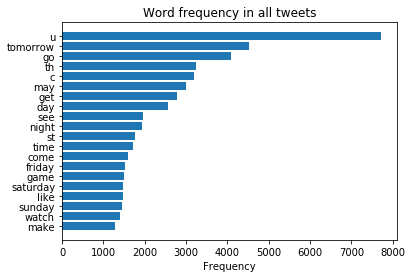

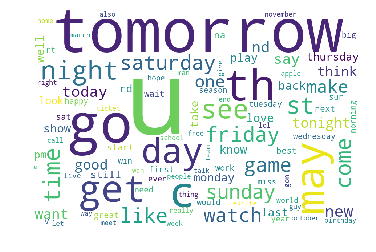

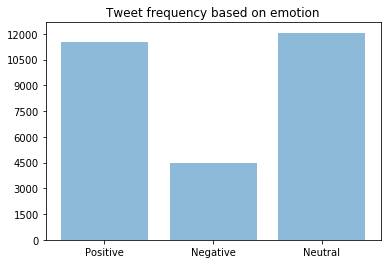

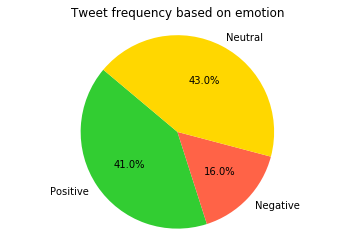

In [118]:
visualize_stats(all_dict, 'Word frequency in all tweets')

# make plot for emotion frequency
emotions = ('Positive', 'Negative', 'Neutral')
freq = [pos_count, neg_count, neu_count]
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.bar(range(len(emotions)), freq, align='center', alpha=0.5)
plt.xticks(range(len(emotions)), emotions)
plt.title('Tweet frequency based on emotion')
plt.show()
plt.close()

# make pie for emotion frequency
sizes = [pos_count / len(train_df.index), neg_count / len(train_df.index), neu_count / len(train_df.index)]
colors = ['limegreen', 'tomato', 'gold']
plt.pie(sizes, labels=emotions, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Tweet frequency based on emotion')
plt.axis('equal')
plt.show()
plt.close()

### Statistics for positive tweets

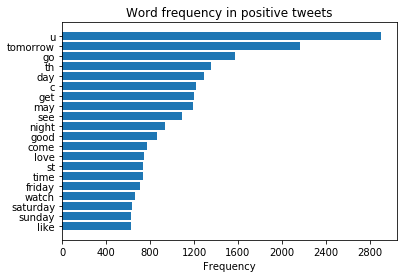

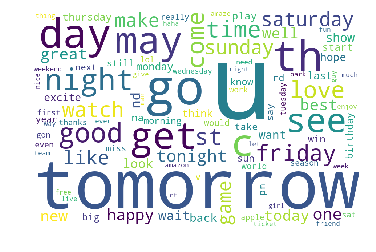

In [119]:
visualize_stats(pos_dict, 'Word frequency in positive tweets')

### Statistics for negative tweets

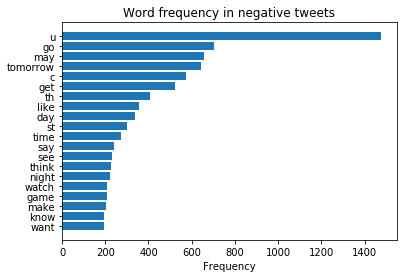

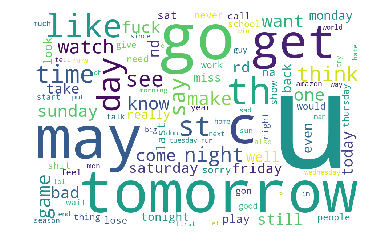

In [120]:
visualize_stats(neg_dict, 'Word frequency in negative tweets')

### Statistics for neutral tweets

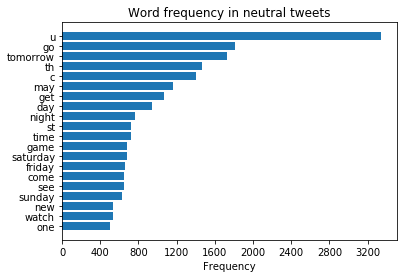

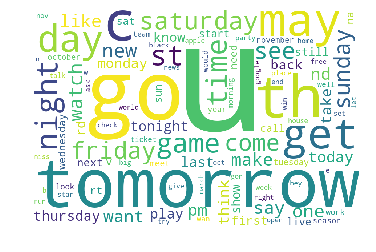

In [121]:
visualize_stats(neu_dict, 'Word frequency in neutral tweets')

## Vectorization


Now we will convert the tokenized tweets to vectors using bag-of-words, Tf-idf and word embeddings.

### Bag-of-words

In [0]:
def dummy(doc):
    """ Dummy tokenizer to use when data are already tokenized. """
    return doc


tweet_list = train_df['Tweet'].tolist()

bow_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features=2000)
matr = bow_vectorizer.fit_transform(tweet_list)

bow_ser = pd.Series(matr.toarray().tolist())
train_df = pd.concat((train_df, bow_ser.rename('BOW')), axis=1)

train_df.head(10)

### Tf-idf

In [133]:
tweet_list = train_df['Tweet'].tolist()

tfidf_vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_features=2000)
matr = tfidf_vectorizer.fit_transform(tweet_list)

tfidf_ser = pd.Series(matr.toarray().tolist())
train_df = pd.concat((train_df, tfidf_ser.rename('TFIDF')), axis=1)

train_df.head(10)

,Id,Number2,Sentiment,Tweet,BOW,TFIDF
0,264183816548130816,15140428,positive,"[gas, house, hit, go, chapel, hill, sat]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,263405084770172928,591166521,negative,"[theo, walcott, still, shit, watch, rafa, john...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,262163168678248449,35266263,negative,"[gsp, fan, hate, nick, diaz, wait, february]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,264249301910310912,18516728,negative,"[iranian, general, say, israel, iron, dome, de...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,262682041215234048,254373818,neutral,"[tehran, mon, amour, obama, try, establish, ti...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,264229576773861376,518129399,neutral,"[sat, whole, movie, harry, ron, christmas, ohl...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,264105751826538497,147088367,positive,"[j, davlar, th, main, rival, team, poland, hop...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,264094586689953794,332474633,negative,"[talk, act, sat, decide, want, go, college, ap...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,212392538055778304,274996324,neutral,"[happy, valentine, day, trend, th, february, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,254941790757601280,557103111,negative,"[may, superbowl, dallas, dallas, win, superbow...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec Models

If you have already run this notebook, you can skip this section and load a pickle with the already trained model

In word embeddings we have two choices: either train our own Word2Vec model or use a pretrained.

Firstly, let's train our own model. If you want to use the pretrained model skip the following section. 

In [143]:
tweet_list = train_df['Tweet'].tolist()

# number of features: 30
model_w2v = Word2Vec(tweet_list, size=50, window=5,
                     min_count=2, sg=1, hs=0, negative=10, workers=2, seed=34)

model_w2v.train(tweet_list, total_examples=len(tweet_list), epochs=20)

(5343712, 6249240)

Let's make a t-SNE plot of our model.

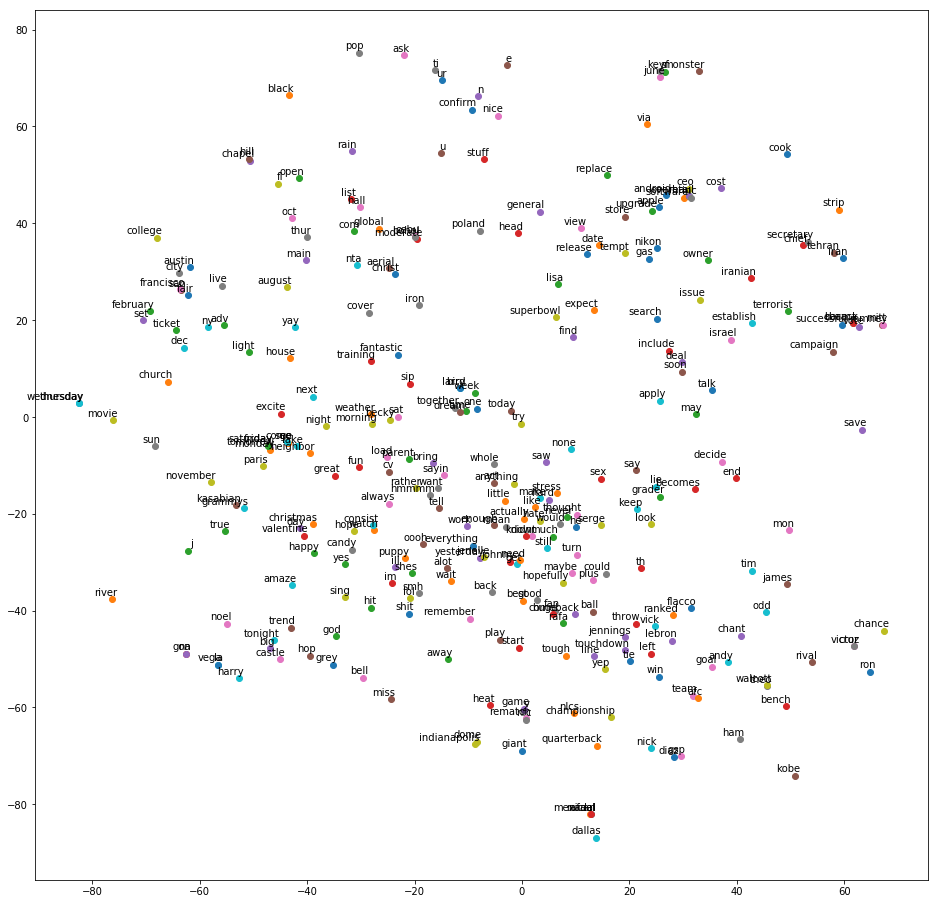

In [142]:
labels = []
tokens = []
for word in model_w2v.wv.vocab:
    tokens.append(model_w2v[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2,
                  init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []

for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
# show only first 300 words
for i in range(300):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(
        5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()
plt.close()

Now, let's use a pretrained model. We will choose [Google News Word Vectors](https://code.google.com/archive/p/word2vec/).

In [0]:
# something...............................

Let's make a t-SNE plot of this pretrained model.

In [0]:
# tsne plot...............................

### Save/Load Word2Vec model to/from pickle

In [0]:
# model_w2v.save('/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/pickles/model_w2v.pkl')
model_w2v = Word2Vec.load('/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/pickles/model_w2v.pkl')

### Word Embeddings

In [145]:
tweet_list = train_df['Tweet'].tolist()
# for each word in a tweet find it's word embedding vector and append it to a list (of vectors)
for i, tweet in enumerate(tweet_list):
    vec_list = []
    for j, word in enumerate(tweet):
        # if word is not in the trained model, create a random vector with number of features same as the other vectors and values between min and max values of features of the previous word (if no previous word create a 0 vector)
        if word not in model_w2v.wv.vocab:
            if j - 1 >= 0:
                size = vec_list[j-1].shape
                min_val = min(vec_list[j-1])
                max_val = max(vec_list[j-1])
                vec = np.random.uniform(
                    low=min_val, high=max_val, size=size)
            else:
                vec = np.zeros(size)
            vec_list.append(vec)
        else:
            vec_list.append(model_w2v[word])
    # convert vec_list to numpy array (an array of vectors)
    arr = np.array(vec_list)
    # change tweet_list item with mean of all the word vectors in the tweet
    tweet_list[i] = arr.mean(axis=1)

we_ser = pd.Series(tweet_list)
train_df = pd.concat((train_df, we_ser.rename('TFIDF')), axis=1)

train_df.head(10)

IndexError: ignored